In [1]:
import joblib
import warnings
import pandas as pd
import numpy as np
from random import choice
from datetime import datetime, timedelta
from bokeh.plotting import figure, show
from bokeh.models import Span
from bokeh.io import output_notebook
from sklearn.metrics import (
    mean_squared_error,
    mean_squared_log_error,
    mean_absolute_error,
    r2_score,
)

dataset_period = [datetime.strptime('2013-07-01', '%Y-%m-%d'), datetime.strptime('2017-10-01', '%Y-%m-%d')]
test_period = [datetime.strptime('2017-10-01', '%Y-%m-%d') - timedelta(days=80), datetime.strptime('2017-10-01', '%Y-%m-%d')]
valid_period = [test_period[0] - timedelta(days=40), test_period[0]]
train_period = [dataset_period[0], valid_period[0]]
predict_time = "H"
sample_station = np.asarray([491,3002, 545, 412, 2000, 3409, 422, 3360, 3382, 3096, 3376, 3400, 3289, 275, 3413, 3329, 3421, 3053, 512, 2017])

output_notebook()
log_path = "logs/lsgnn"
warnings.filterwarnings("ignore")

Loading BokehJS ...

In [2]:
def caculate_loss(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)

    print("rmse:%f  rmsle:%f  mae:%f  corr:%f  r2:%f" % (rmse, rmsle, mae, corr, r2))

In [3]:
def draw_picture(df):
    df["y_pred"] = np.around(df["y_pred"].values)
    p = figure(
        plot_width=1500,
        plot_height=500,
        x_axis_type="datetime",
        x_axis_label="time",
        y_axis_label="flow",
    )
    p.xaxis.axis_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"

    for column, color in zip(["y", "y_pred"], ["#FF0000", "#00BFFF"]):
        p.line(df.time, df[column], color=color, legend_label=column)
        p.circle(df.time, df[column], color=color, line_width=0.25, legend_label=column)

    p.legend.location = "top_right"
    p.legend.label_text_font_size = "20pt"
    p.legend.click_policy = "hide"
    show(p)

    p = figure(
        plot_width=1500, plot_height=500, x_axis_label="target", y_axis_label="predict",
    )
    p.xaxis.axis_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"

    p.circle(df.y, df.y_pred, line_width=0.25)
    show(p)

In [4]:
features = pd.read_hdf('process_data/features_201307_201709.h5', key='features')
station_info = pd.read_hdf("process_data/features_201307_201709.h5", key="info")
alive_df = pd.read_hdf("process_data/features_201307_201709.h5", key="alive")
alive_df = alive_df.query('@test_period[0] <= time < @test_period[1]')
predict_df = features[['time','stationid','y_in', 'y_out']].query('@test_period[0] <= time < @test_period[1] & @alive_df.is_alive == 1')
predicts = np.load(f"{log_path}/predicts.npy")
predict_df['y_in_pred'] = predicts[:,0]
predict_df['y_out_pred'] = predicts[:,1]

In [5]:
predict_df_in = (
    predict_df
    .rename(columns={"y_in_pred": "y_pred", "y_in": "y"})
)
predict_df_out = (
    predict_df
    .rename(columns={"y_out_pred": "y_pred", "y_out": "y"})
)

stationid_sort = predict_df.groupby('stationid')['y_in'].sum().sort_values(ascending=False).index

# Total Loss

In [6]:
print("IN")
caculate_loss(predict_df_in.y.values, predict_df_in.y_pred.values)
print("\n")
print("OUT")
caculate_loss(predict_df_out.y.values, predict_df_out.y_pred.values)
print("\n")
print(f"MEAN IN:{predict_df_in.y.mean()}|MEAN OUT:{predict_df_out.y.mean()}")
print(f"STD IN:{predict_df_in.y.std()}|STD OUT:{predict_df_out.y.std()}")

IN
rmse:2.682094  rmsle:0.483088  mae:1.530344  corr:0.914653  r2:0.834008


OUT
rmse:2.824671  rmsle:0.495038  mae:1.589048  corr:0.906113  r2:0.819017


MEAN IN:3.868508017078426|MEAN OUT:3.868203163210004
STD IN:6.583105898857261|STD OUT:6.639713972154361


# Top 5 Loss

In [7]:
top_in = predict_df_in[predict_df_in.stationid.isin(stationid_sort[:5])]
top_out = predict_df_out[predict_df_out.stationid.isin(stationid_sort[:5])]
print("IN")
caculate_loss(top_in.y.values, top_in.y_pred.values)
print("\n")
print("OUT")
caculate_loss(top_out.y.values, top_out.y_pred.values)
print("\n")
print(f"MEAN IN:{top_in.y.mean()}|MEAN OUT:{top_out.y.mean()}")
print(f"STD IN:{top_in.y.std()}|STD OUT:{top_out.y.std()}")

IN
rmse:7.040835  rmsle:0.482043  mae:4.424228  corr:0.945233  r2:0.889956


OUT
rmse:7.556141  rmsle:0.499779  mae:4.627099  corr:0.943303  r2:0.886272


MEAN IN:18.183125|MEAN OUT:17.635520833333334
STD IN:21.225821052359954|STD OUT:22.407313201368957


# Top 10 Loss

In [8]:
top_in = predict_df_in[predict_df_in.stationid.isin(stationid_sort[:10])]
top_out = predict_df_out[predict_df_out.stationid.isin(stationid_sort[:10])]
print("IN")
caculate_loss(top_in.y.values, top_in.y_pred.values)
print("\n")
print("OUT")
caculate_loss(top_out.y.values, top_out.y_pred.values)
print("\n")
print(f"MEAN IN:{top_in.y.mean()}|MEAN OUT:{top_out.y.mean()}")
print(f"STD IN:{top_in.y.std()}|STD OUT:{top_out.y.std()}")

IN
rmse:6.311230  rmsle:0.461519  mae:3.990096  corr:0.941483  r2:0.881923


OUT
rmse:6.996050  rmsle:0.483154  mae:4.189957  corr:0.936091  r2:0.870322


MEAN IN:16.17380208333333|MEAN OUT:15.842239583333333
STD IN:18.367155886458367|STD OUT:19.428129568677356


# 尖峰 Loss

In [9]:
"""
先把y值為0數據拿掉，再以95百分為高峰門檻
"""
print("IN threashold:%i" % (predict_df_in.query("y > 0").y.quantile(0.95)))
print("OUT threashold:%i" % (predict_df_out.query("y > 0").y.quantile(0.95)))

IN threashold:20
OUT threashold:19


In [10]:
top_in = predict_df_in.query("y >= 20")
top_out = predict_df_out.query("y >= 19")
print("IN")
caculate_loss(top_in.y.values, top_in.y_pred.values)
print("\n")

print("OUT")
caculate_loss(top_out.y.values, top_out.y_pred.values)
print("\n")
print(f"MEAN IN:{top_in.y.mean()}|MEAN OUT:{top_out.y.mean()}")
print(f"STD IN:{top_in.y.std()}|STD OUT:{top_out.y.std()}")

IN
rmse:9.147926  rmsle:0.353625  mae:7.090597  corr:0.833079  r2:0.487152


OUT
rmse:9.660765  rmsle:0.387180  mae:7.362872  corr:0.826561  r2:0.490891


MEAN IN:29.41846883607059|MEAN OUT:28.318963133640555
STD IN:12.774210067831154|STD OUT:13.539769820440169


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

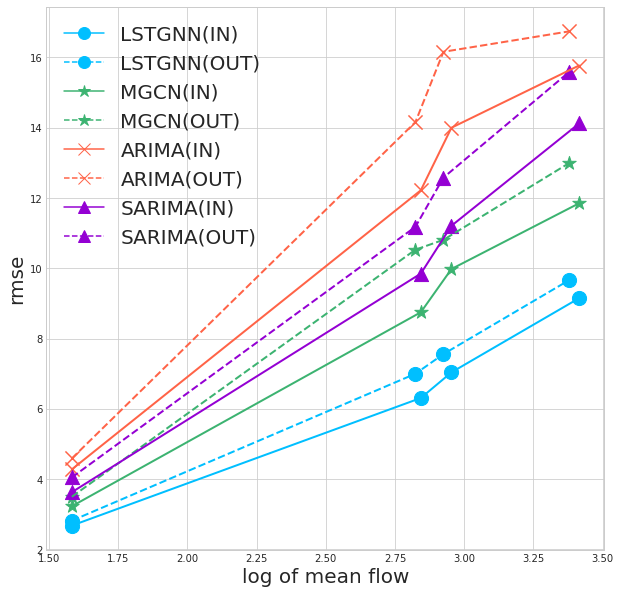

In [43]:
x_in = np.log1p(np.array([3.868508017078426, 16.17380208333333, 18.183125, 29.41846883607059]))
x_out = np.log1p(np.array([3.868203163210004, 15.842239583333333, 17.635520833333334, 28.318963133640555]))

plt.figure(figsize=(10,10))
plt.plot(x_in, [2.68, 6.31, 7.04, 9.15], color='deepskyblue', linewidth=2)
plt.scatter(x_in, [2.68, 6.31, 7.04, 9.15], color='deepskyblue', s=200)
plt.plot([], [], '-o', color='deepskyblue', label='LSTGNN(IN)')

plt.plot(x_out, [2.82, 7.00, 7.56, 9.66], color='deepskyblue', linewidth=2, linestyle='--')
plt.scatter(x_out, [2.82, 7.00, 7.56, 9.66], color='deepskyblue', s=200 )
plt.plot([], [], '--o', color='deepskyblue', label='LSTGNN(OUT)')

plt.plot(x_in, [3.23, 8.75, 9.98, 11.85], color='mediumseagreen', linewidth=2)
plt.scatter(x_in, [3.23, 8.75, 9.98, 11.85], color='mediumseagreen', marker='*', s=200)
plt.plot([], [], '-*', color='mediumseagreen', label='MGCN(IN)')

plt.plot(x_out, [3.50, 10.53, 10.81, 12.99], color='mediumseagreen', linewidth=2, linestyle='--')
plt.scatter(x_out, [3.50, 10.53, 10.81, 12.99], color='mediumseagreen', marker='*', s=200)
plt.plot([], [], '--*', color='mediumseagreen', label='MGCN(OUT)')

plt.plot(x_in, [4.28, 12.22, 14.00, 15.77], color='tomato', linewidth=2)
plt.scatter(x_in, [4.28, 12.22, 14.00, 15.77], color='tomato', marker='x', s=200)
plt.plot([], [], '-x', color='tomato', label='ARIMA(IN)')

plt.plot(x_out, [4.59, 14.16, 16.16, 16.74], color='tomato', linewidth=2, linestyle='--')
plt.scatter(x_out, [4.59, 14.16, 16.16, 16.74], color='tomato', marker='x', s=200)
plt.plot([], [], '--x', color='tomato', label='ARIMA(OUT)')

plt.plot(x_in, [3.63, 9.85, 11.21, 14.12], color='darkviolet', linewidth=2)
plt.scatter(x_in, [3.63, 9.85, 11.21, 14.12], color='darkviolet', marker='^', s=200)
plt.plot([], [], '-^', color='darkviolet', label='SARIMA(IN)')

plt.plot(x_out, [4.05, 11.18, 12.58, 15.58], color='darkviolet', linewidth=2, linestyle='--')
plt.scatter(x_out, [4.05, 11.18, 12.58, 15.58], color='darkviolet', marker='^', s=200)
plt.plot([], [], '--^', color='darkviolet', label='SARIMA(OUT)')

plt.legend(prop={'size': 20}, markerscale=2)
plt.xlabel("log of mean flow", fontsize=20)
plt.ylabel("rmse", fontsize=20)
plt.savefig("mean_flow_rmse")
plt.show()

# 場站預測流量圖

In [ ]:
def draw_picture_plt(df, filename):
    df["y_pred"] = np.around(df["y_pred"].values)
    plt.figure(figsize=(25,10))
    
    plt.plot(df.time, df.y_pred, color='deepskyblue', linewidth=2, label='prediction')
    plt.scatter(df.time, df.y_pred, color='deepskyblue', linewidth=2)
    plt.plot(df.time, df.y, color='tomato', linewidth=2, label='obseration')
    plt.scatter(df.time, df.y, color='tomato', linewidth=2)
    
    plt.legend(prop={'size': 20})
    plt.xlabel("time", fontsize=25)
    plt.ylabel("flow", fontsize=25)
    plt.xticks(fontsize=15)
    plt.savefig(filename)
    plt.show()

In [ ]:
no = stationid_sort[0]
# no = stationid_sort[5]
df = predict_df_in.query("stationid == @no")
df = df[(df.time >= datetime.strptime('2017-08-14', '%Y-%m-%d')) & (df.time < datetime.strptime('2017-08-21', '%Y-%m-%d'))]
# df = df[(df.time >= datetime.strptime('2017-08-31', '%Y-%m-%d')) & (df.time < datetime.strptime('2017-09-06', '%Y-%m-%d'))]
draw_picture_plt(df, "LSTGNN_normal")
# draw_picture_plt(df, "LSTGNN_labor")

In [ ]:
no = stationid_sort[0]
df = predict_df_in.query("stationid == @no")
caculate_loss(df.y.values, df.y_pred.values)
draw_picture(df)

df = predict_df_out.query("stationid == @no")
caculate_loss(df.y.values, df.y_pred.values)
draw_picture(df)

# 散點圖表示流量與loss

In [ ]:
def caculate_loss_df(df):
    y_true = df.y.values
    y_pred = df.y_pred.values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)

    return pd.DataFrame(
        {
            "sum_flow": df.y.sum(),
            "mean_flow": df.y.mean(),
            "median_flow": df.y.median(),
            "rmse": [rmse],
            "rmsle": [rmsle],
            "mae": [mae],
            "corr": [corr],
            "r2": [r2],
        }
    )

In [ ]:
def draw_loss_picture(df):
    for column in ["rmse", "rmsle", "mae", "corr", "r2"]:
        p = figure(
            plot_width=1000, plot_height=500, x_axis_label="flow", y_axis_label=column,
        )
        p.xaxis.axis_label_text_font_size = "20pt"
        p.yaxis.axis_label_text_font_size = "20pt"

        p.circle(df.flow, df[column], line_width=0.25)
        show(p)

In [ ]:
df = pd.concat(
    [
        predict_df_in.groupby("stationid").apply(caculate_loss_df).reset_index(level=0).set_index('stationid').add_prefix('in_'),
        predict_df_out.groupby("stationid").apply(caculate_loss_df).reset_index(level=0).set_index('stationid').add_prefix('out_')
    ],
    axis=1,
).sort_values('in_sum_flow', ascending=False)

In [ ]:
df.to_csv(f'{log_path}/performance.csv')

# IN

In [ ]:
draw_loss_picture(
    predict_df_in.groupby("stationid").apply(caculate_loss_df).reset_index(level=0)
)

# OUT

In [ ]:
draw_loss_picture(
    predict_df_out.groupby("stationid").apply(caculate_loss_df).reset_index(level=0)
)